# Quality control for Ernst et al study

1. Correlation between replicates is strongly a function of the plasmid count.
2. Lower plasmid counts result in higher variability, inflating activities.
3. Some experiments have greatly different library complexity between replicates. This perhaps represents some sort of transfection efficiency issue?
4. DESeq2 is able to correctly predict the variance between replicates based on thier counts.
5. LFC with a pseudocount of 1 is likely a good statistic to stick with.
6. DESeq2 pvalues can be used to partition the data into a set of DE oligos that are highly correlated and not DE oligos that are barely correlated.
7. Overall this leads me to think that a hybrid classification (DE v. not DE) and regression (only on DE) model, perhaps weighted by the (inverse square of) the DESeq2 SE estimates will be successful.

In [1]:
import pandas
import glob
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

from plotting import quantile_plot
from make_counts_table_kellis import read_data

cells = ["HepG2", "K562"]
designs = ["ScaleUpDesign1", "ScaleUpDesign2"]
promoters = ["minP", "SV40P"]

# Read in Data

In [2]:
names, seqs, rna1, rna2, dna, header = read_data()

['../enhancer_data/kellis/raw/GSM1831757_HepG2_ScaleUpDesign1_minP_mRNA_Rep1.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831758_HepG2_ScaleUpDesign1_minP_mRNA_Rep2.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831773_ScaleUpDesign1_minP_Plasmid.counts.txt.gz']
['../enhancer_data/kellis/raw/GSM1831765_K562_ScaleUpDesign1_minP_mRNA_Rep1.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831766_K562_ScaleUpDesign1_minP_mRNA_Rep2.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831773_ScaleUpDesign1_minP_Plasmid.counts.txt.gz']
['../enhancer_data/kellis/raw/GSM1831759_HepG2_ScaleUpDesign1_SV40P_mRNA_Rep1.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831760_HepG2_ScaleUpDesign1_SV40P_mRNA_Rep2.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831774_ScaleUpDesign1_SV40P_Plasmid.counts.txt.gz']
['../enhancer_data/kellis/raw/GSM1831767_K562_ScaleUpDesign1_SV40P_mRNA_Rep1.counts.txt.gz'] ['../enhancer_data/kellis/raw/GSM1831768_K562_ScaleUpDesign1_SV40P_mRNA_Rep2.counts.txt.gz'] 

# RNA counts between replicates are well correlated

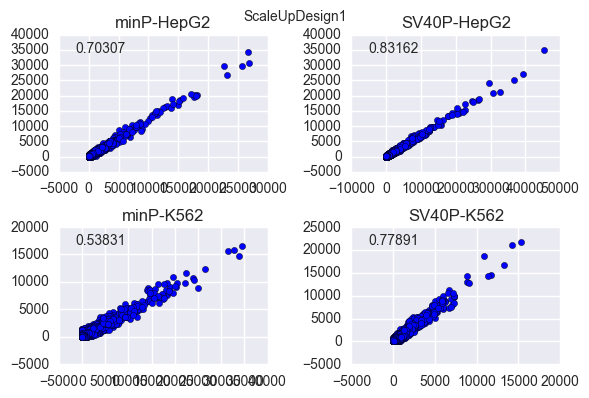

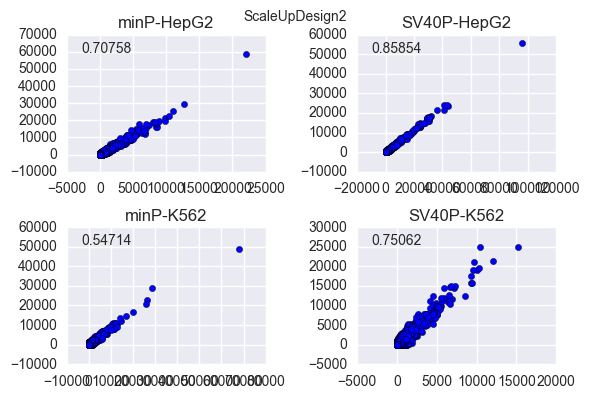

In [3]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(0, 4):
        ax[i%2, i/2].set_title(header[i])
        ax[i%2, i/2].scatter(rna1[designs[j]][:, i],
                             rna2[designs[j]][:, i])
        spear = stats.spearmanr(rna1[designs[j]][:, i],
                                rna2[designs[j]][:, i])[0]
        
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
    plt.tight_layout()
    plt.show()

# Histograms of RNA counts

The density distribution varies greatly between experiments... similar for replicates.

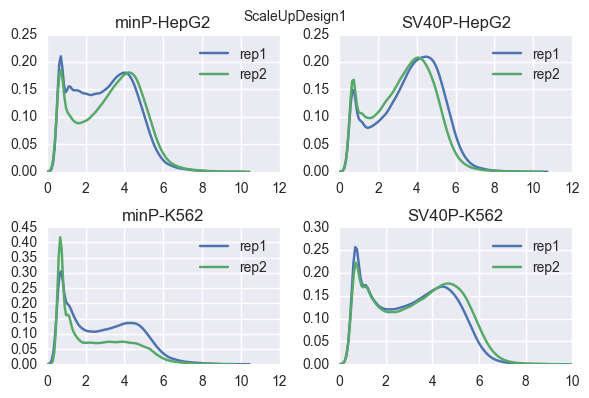

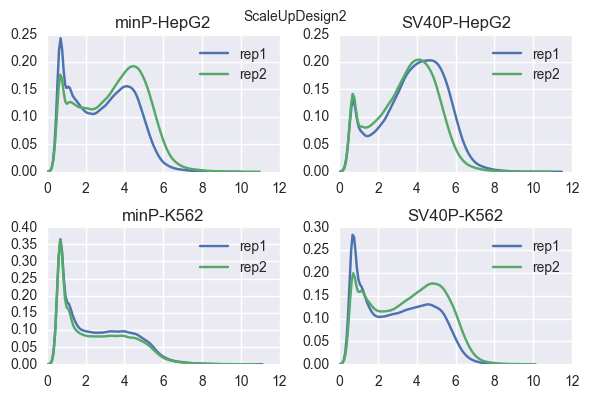

In [4]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(0, 4):
        ax[i%2, i/2].set_title(header[i])
        
        sns.kdeplot(np.log(rna1[designs[j]][:, i] + 1),
                    cut = 0, ax = ax[i%2, i/2], label = 'rep1')
        sns.kdeplot(np.log(rna2[designs[j]][:, i] + 1),
                    cut = 0, ax = ax[i%2, i/2], label = 'rep2')
        
    plt.tight_layout()
    plt.show()

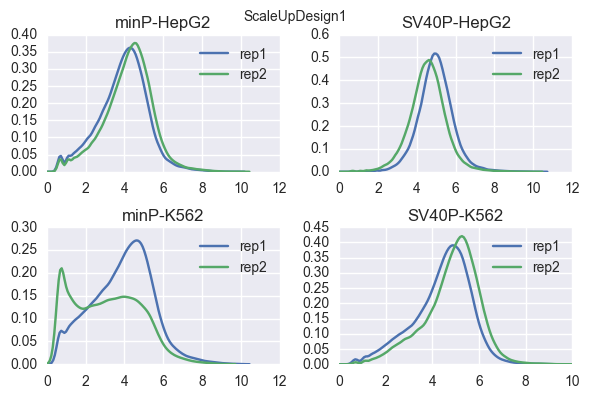

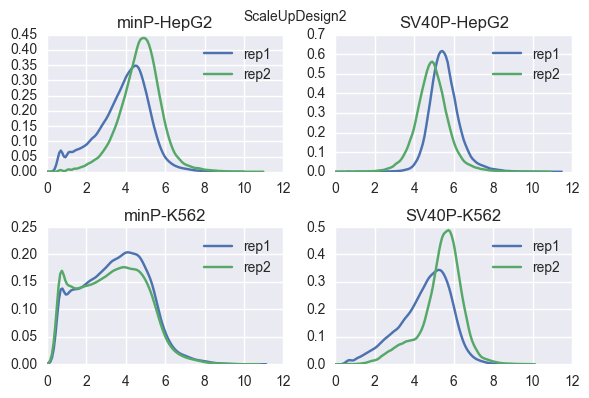

In [5]:
# Only for high DNA counts
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(0, 4):
        ax[i%2, i/2].set_title(header[i])
        valid = dna[designs[j]][:, i] > 100
        sns.kdeplot(np.log(rna1[designs[j]][:, i] + 1)[valid],
                    cut = 0, ax = ax[i%2, i/2], label = 'rep1')
        sns.kdeplot(np.log(rna2[designs[j]][:, i] + 1)[valid],
                    cut = 0, ax = ax[i%2, i/2], label = 'rep2')
        
    plt.tight_layout()
    plt.show()

# Histograms of DNA counts

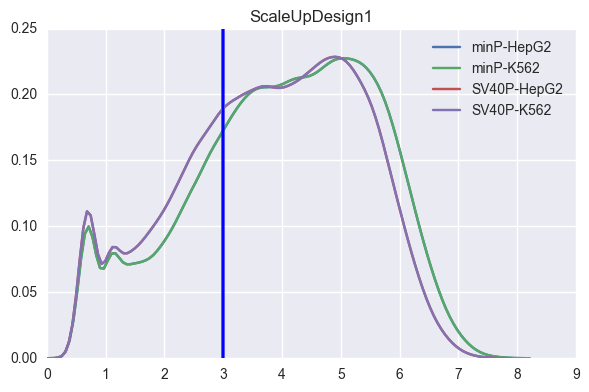

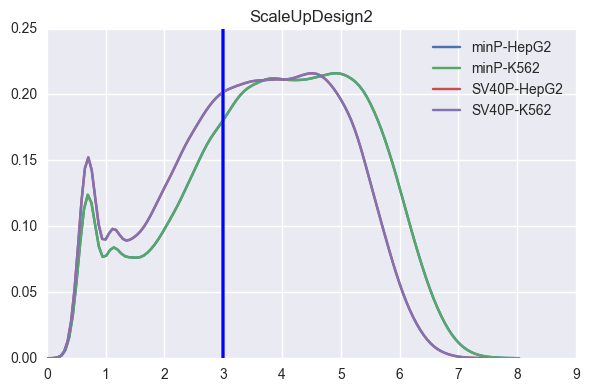

In [6]:
# Note that there is only one DNA count per library
for j in range(2):
    plt.title(designs[j])
    for i in range(4):
        sns.kdeplot(np.log(dna[designs[j]][:, i] + 1),
                    cut = 0, label = header[i])
        plt.axvline(np.log(20))
    plt.tight_layout()
    plt.show()

# Histograms of Activities

Normalized with high DNA counts.

In [7]:
def act(rna, dna, thresh = 20):
    rna, dna = rna[dna > thresh], dna[dna > thresh]
    return (np.log(rna + 1) - np.log(dna + 1)
            - np.log(sum(rna + 1)) + np.log(sum(dna + 1)))

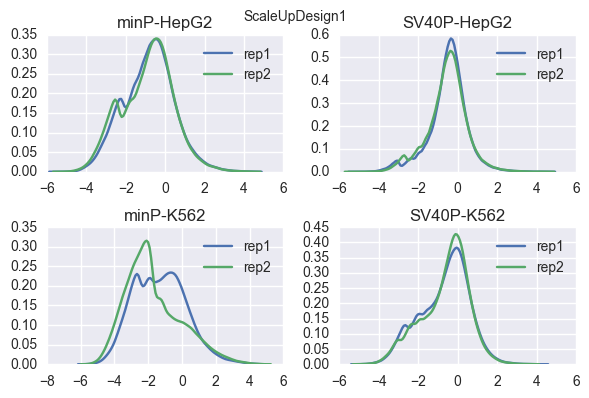

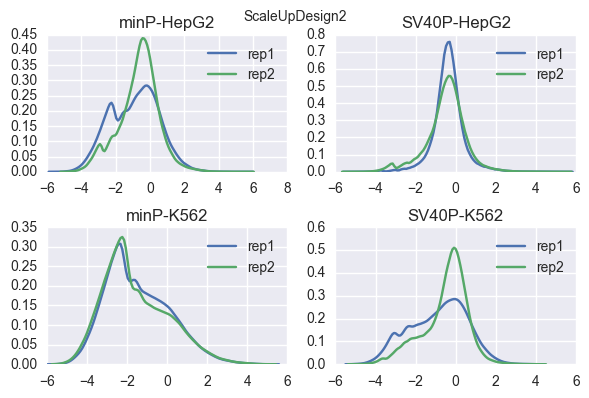

In [8]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(0, 4):
        ax[i%2, i/2].set_title(header[i])
        
        sns.kdeplot(act(rna1[designs[j]][:, i], dna[designs[j]][:, i]),
                    cut = 0, ax = ax[i%2, i/2], label = 'rep1')
        sns.kdeplot(act(rna2[designs[j]][:, i], dna[designs[j]][:, i]),
                    cut = 0, ax = ax[i%2, i/2], label = 'rep2')
        
    plt.tight_layout()
    plt.show()

# Scatter plots of activities

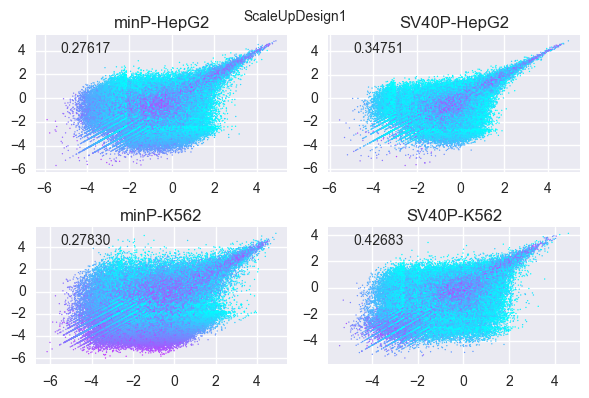

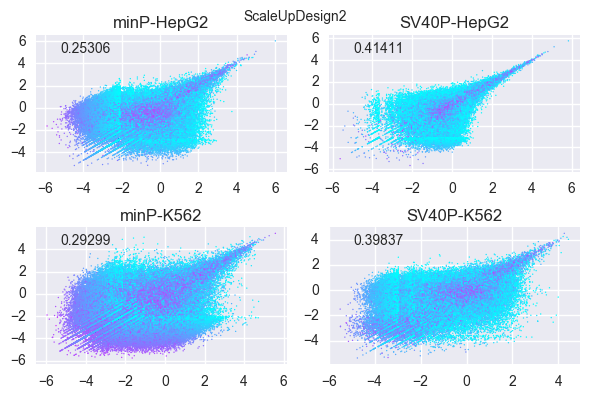

In [9]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        
        ax[i%2, i/2].scatter(act(r1, d), act(r2, d),
                        c = np.log(d+1)[d > 20], cmap = 'cool',
                        s = 1, lw = 0)
        
        spear = stats.spearmanr(act(r1, d), act(r2, d))[0]
        
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

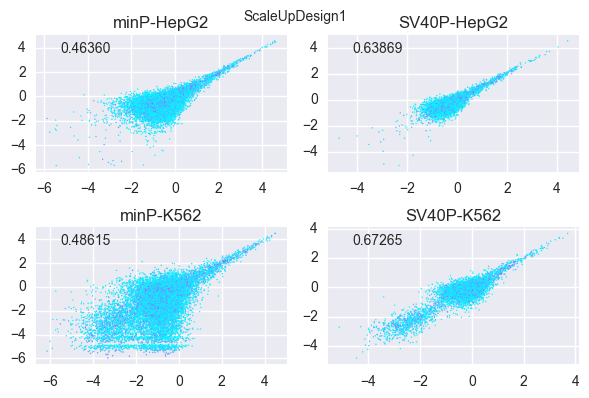

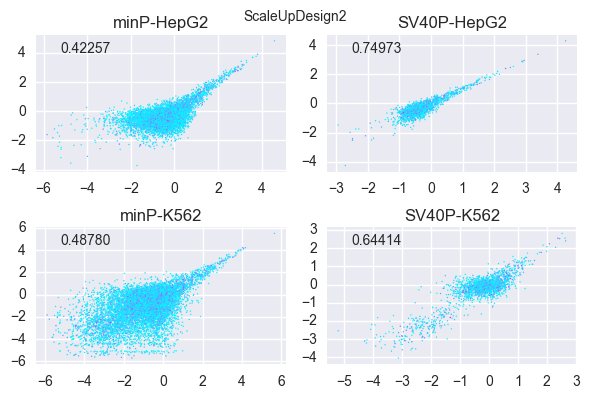

In [10]:
thresh = 500
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        
        ax[i%2, i/2].scatter(act(r1, d, thresh), act(r2, d, thresh),
                        c = np.log(d+1)[d > thresh], cmap = 'cool',
                        s = 1, lw = 0)
        
        spear = stats.spearmanr(act(r1, d, thresh), act(r2, d, thresh))[0]
        
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# DNA count v. Variance

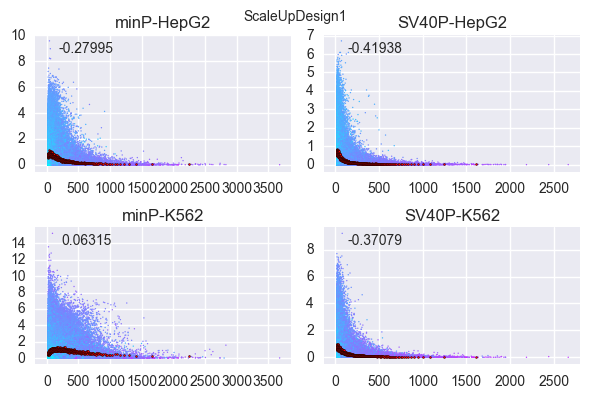

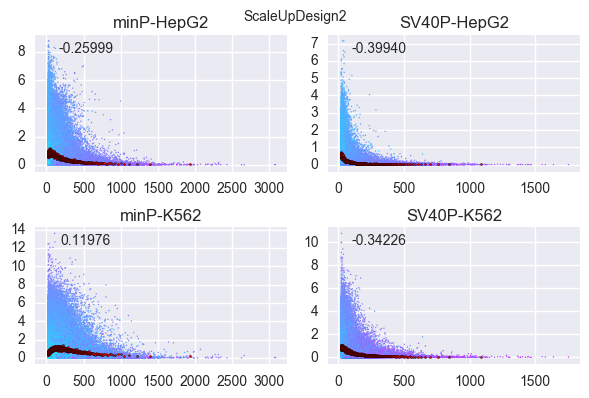

In [11]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        var = np.var(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        
        ax[i%2, i/2].scatter(d[d > 20], var,
                        c = np.log((r1 + r2 + 2) / 2.0)[d > 20],
                        cmap = 'cool',
                        s = 1, lw = 0)
        
        quantile_plot(d[d > 20],
                      var, 1000, ax[i%2, i/2], s = 2)
        
        spear = stats.spearmanr(np.log(d + 1)[d > 20], var)[0]
        
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# RNA count v. Variance

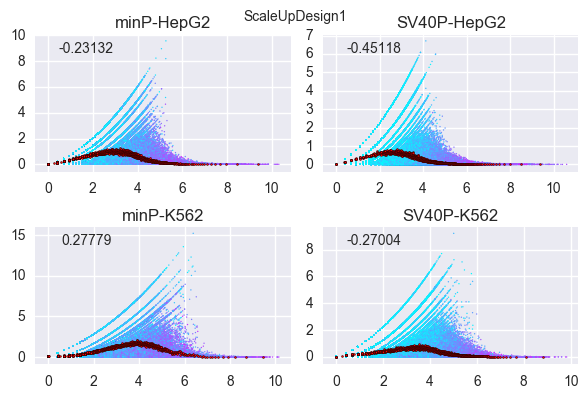

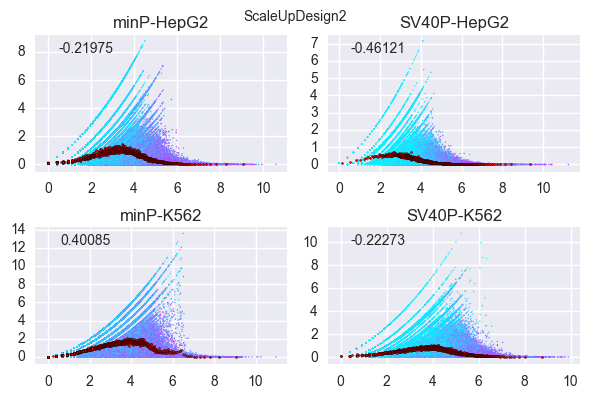

In [12]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        var = np.var(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        
        ax[i%2, i/2].scatter(np.log((r1 + r2 + 2) / 2.0)[d > 20], var,
                        c = np.log(d + 1)[d > 20],
                        cmap = 'cool',
                        s = 1, lw = 0)
        
        spear = stats.spearmanr(np.log((r1 + r2 + 2) / 2.0)[d > 20],
                                var)[0]
        
        quantile_plot(np.log((r1 + r2 + 2) / 2.0)[d > 20],
                      var, 1000, ax[i%2, i/2], s = 2)
        
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# Activity versus Variance

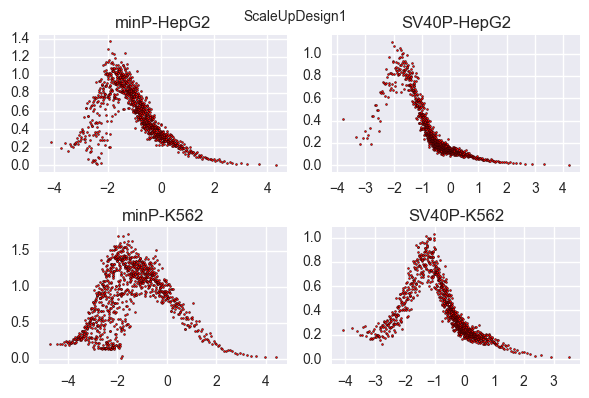

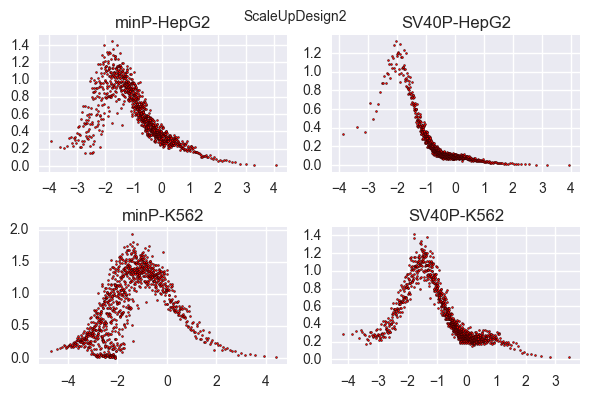

In [13]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        var = np.var(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        
        quantile_plot(m, var, 1000, ax[i%2, i/2], s = 2)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# Activity v. DNA Count

We observe that there is a dependence between activity and DNA count!

This is very problematic.

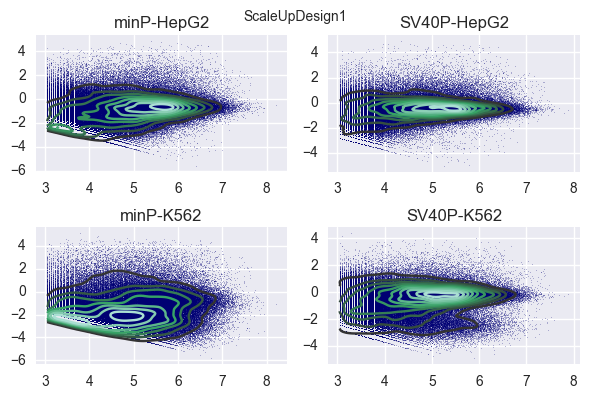

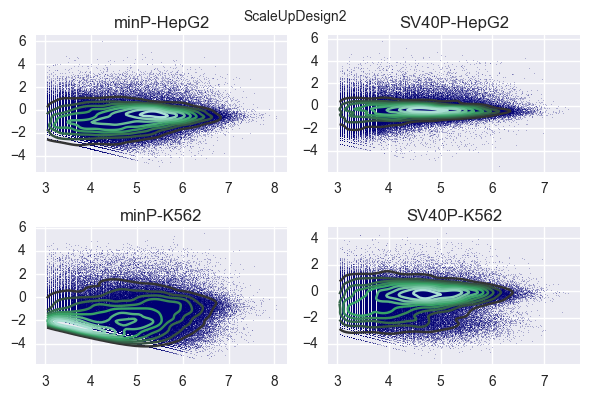

In [14]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        ax[i%2, i/2].scatter(np.log(d[d > 20]), m, s = .1, lw = 0)
        sns.kdeplot(np.log(d[d > 20])[:10000], m[:10000],
                    ax = ax[i%2, i/2], cut = 0)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

SpearmanrResult(correlation=0.21834897891179242, pvalue=0.0)
SpearmanrResult(correlation=0.055022049972547581, pvalue=8.1137157671105077e-114)
SpearmanrResult(correlation=0.17361168754946305, pvalue=0.0)
SpearmanrResult(correlation=0.19957996479480794, pvalue=0.0)


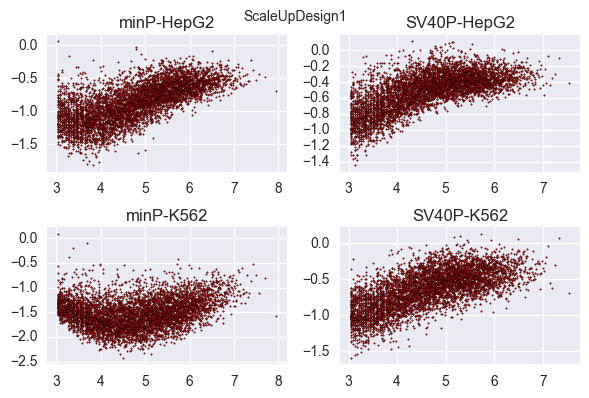

SpearmanrResult(correlation=0.2220585105391554, pvalue=0.0)
SpearmanrResult(correlation=0.082625495298760204, pvalue=3.3049762923776835e-239)
SpearmanrResult(correlation=0.11659676919972242, pvalue=0.0)
SpearmanrResult(correlation=0.19961158390540035, pvalue=0.0)


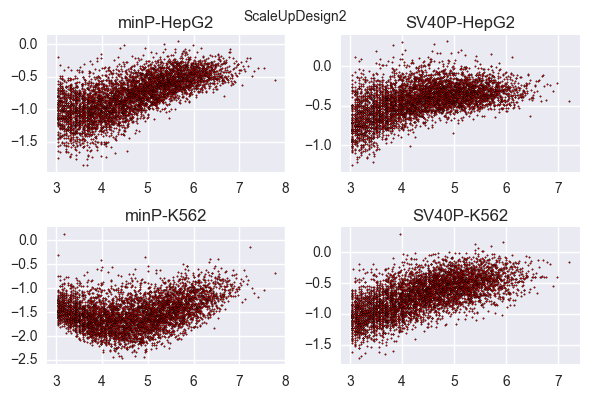

In [15]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        print stats.spearmanr(m, d[d > 20])
        quantile_plot(np.log(d[d > 20]), m, 5000, ax[i%2, i/2], s = 1)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

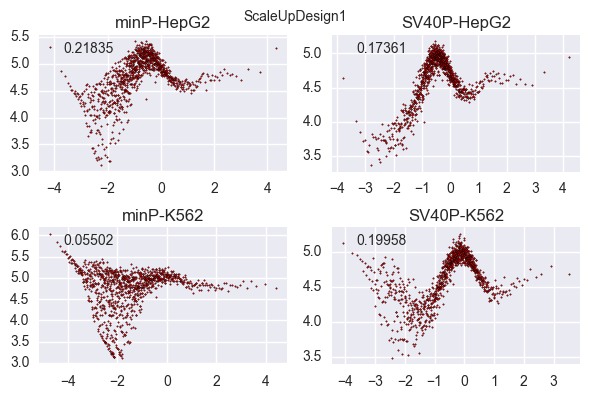

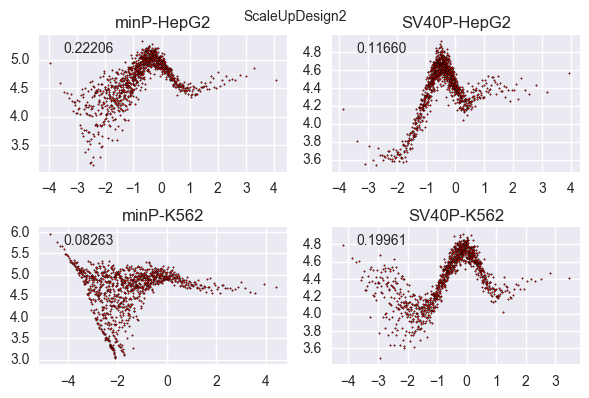

In [16]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        spear = stats.spearmanr(m, d[d > 20])[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        quantile_plot(m, np.log(d[d > 20]), 1000, ax[i%2, i/2], s = 1)
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# DNA v. RNA

This is really important because the activity scores are just log(RNA) - log(DNA).

It is apparent that there is not a general linear trend between the two.
This is problematic because it will result in biases in activity.

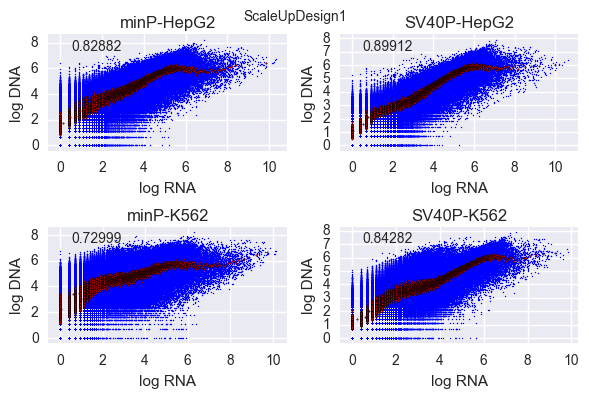

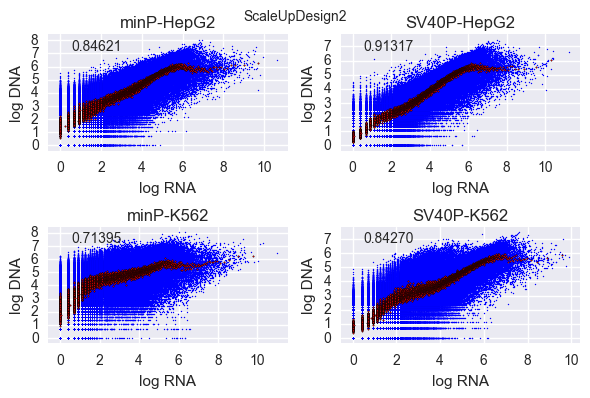

In [17]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([r1,r2]).T, axis = 1)
        spear = stats.spearmanr(m, d)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].scatter(np.log(m + 1), np.log(d + 1), s=1, lw = 0)
        quantile_plot(np.log(m + 1), np.log(d + 1),
                      5000, ax[i%2, i/2], s = 1)
        ax[i%2, i/2].set_xlabel('log RNA')
        ax[i%2, i/2].set_ylabel('log DNA')
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

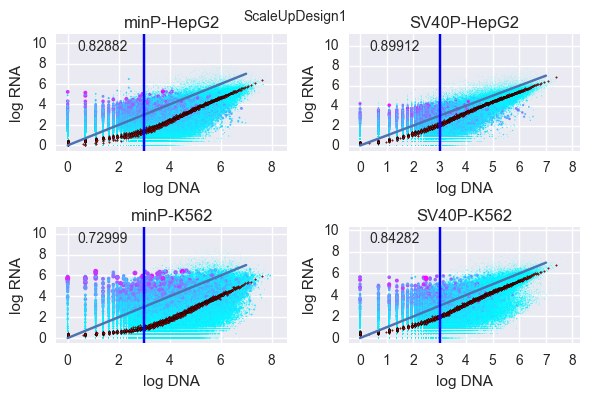

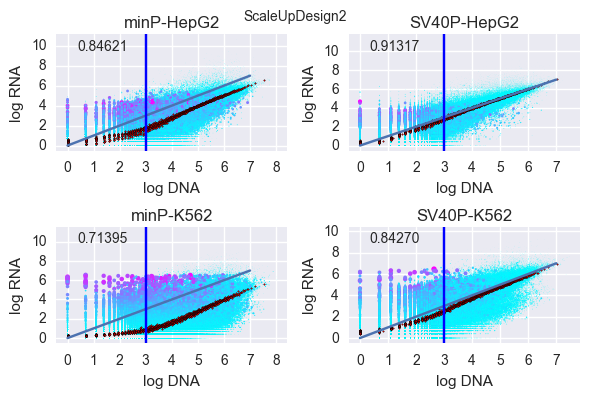

In [18]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([r1,r2]).T, axis = 1)
        var = np.var(np.vstack([act(r1, d, -1), act(r2, d, -1)]).T,
                     axis = 1)
        spear = stats.spearmanr(m, d)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].scatter(np.log(d + 1), np.log(m + 1),
                             c = var,cmap='cool', s=var, lw = 0)
        quantile_plot(np.log(d + 1), np.log(m + 1),
                      1000, ax[i%2, i/2], s = 1)
        ax[i%2, i/2].plot([0, 7], [0, 7])
        ax[i%2, i/2].axvline(np.log(20))
        ax[i%2, i/2].set_xlabel('log DNA')
        ax[i%2, i/2].set_ylabel('log RNA')
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# DESeq2

In [19]:
DE_DIR = '../enhancer_data/kellis/de'

lfc = {}
lfc_mle = {}
lfc_se = {}
pvals = {}
for design in designs:
    lfc[design] = []
    lfc_mle[design] = []
    lfc_se[design] = []
    pvals[design] = []
    for promoter in promoters:
        for cell in cells:  
            with open("{}/{}-{}-{}.deseq".format(DE_DIR, design, promoter.upper(), cell)) as fp:
                fp.readline()
                lfc[design] += [[]]
                lfc_mle[design] += [[]]
                lfc_se[design] += [[]]
                pvals[design] += [[]]
                for line in fp:
                    name, mean, lf2c, lf2c_mle, lf2c_se, stat, pval, padj = line.strip().split('\t')
                    lfc[design][-1]        += [float(0 if lf2c     == 'NA' else lf2c)]
                    lfc_mle[design][-1]    += [float(0 if lf2c_mle == 'NA' else lf2c_mle)]
                    lfc_se[design][-1]     += [float(0 if lf2c_se  == 'NA' else lf2c_se)]
                    pvals[design][-1]      += [float(1 if pval     == 'NA' else pval)]
    lfc[design] = np.vstack(lfc[design]).T
    lfc_mle[design] = np.vstack(lfc_mle[design]).T
    lfc_se[design] = np.vstack(lfc_se[design]).T
    pvals[design] = np.vstack(pvals[design]).T

# Compare MLE estimates to shrunken estimates

Note that the 'activities' differ from the MLE estimates in that they
are log(RNA + 1) - log(DNA + 1), while the MLE estimates lack the psuedocount.

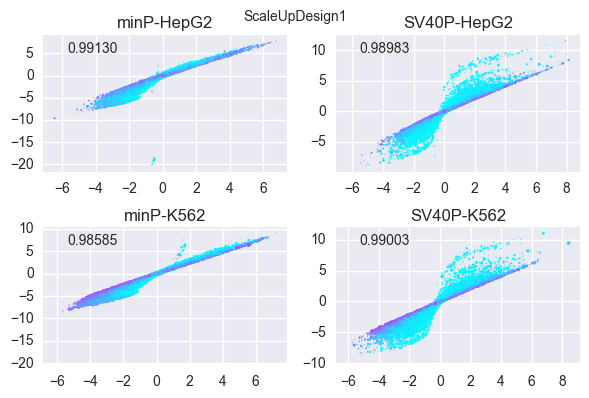

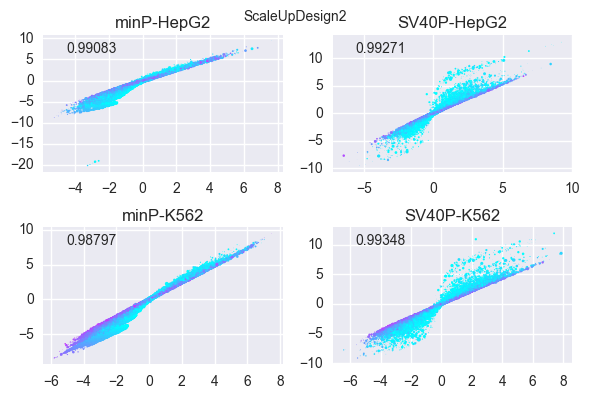

In [20]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        mle = lfc_mle[designs[j]][:, i][d > 20]
        m =       lfc[designs[j]][:, i][d > 20]
        
        spear = stats.spearmanr(m, mle)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].scatter(m, mle,
                             c = np.log(d + 1)[d > 20], cmap='cool', s=var, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

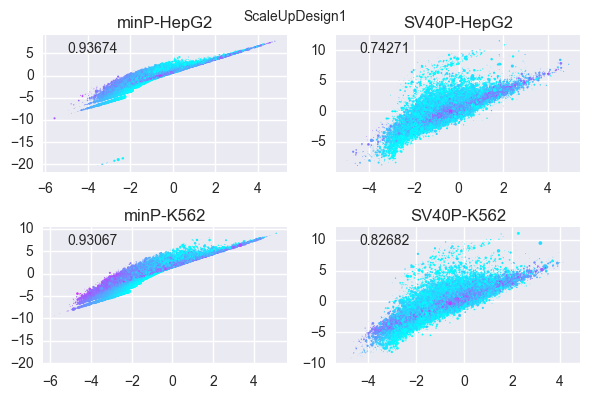

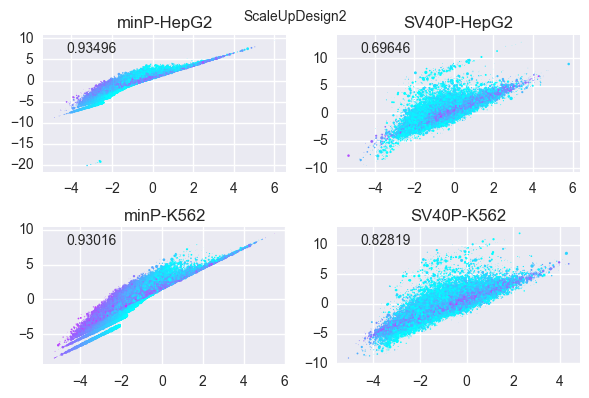

In [21]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        mle = lfc_mle[designs[j]][:, i][d > 20]
        
        spear = stats.spearmanr(m, mle)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].scatter(m, mle,
                             c = np.log(d + 1)[d > 20], cmap='cool', s=var, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

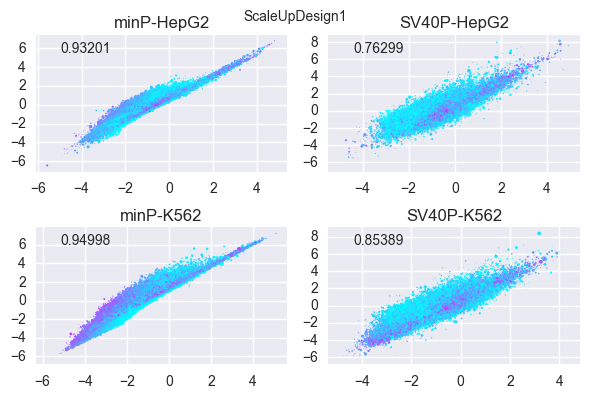

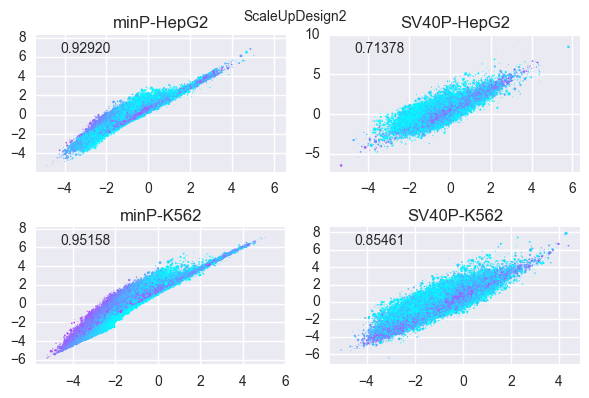

In [22]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        s = lfc[designs[j]][:, i][d > 20]
        
        spear = stats.spearmanr(m, s)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        ax[i%2, i/2].scatter(m, s,
                             c = np.log(d + 1)[d > 20], cmap='cool', s=var, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# Evaluate Performance of SE estimates

DESeq SE estimates seem to do a good job predicting variance

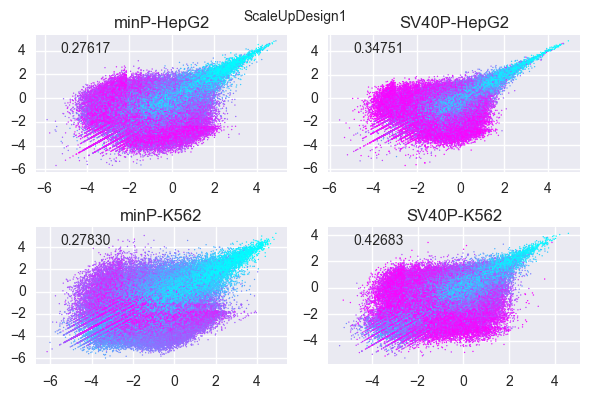

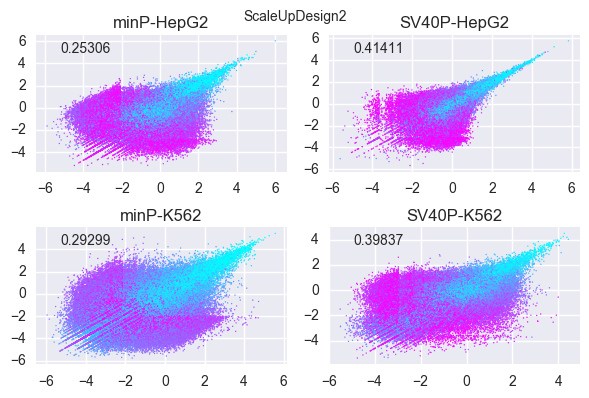

In [23]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        a1, a2 = act(r1, d), act(r2, d)
        se = lfc_se[designs[j]][:, i]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        ax[i%2, i/2].scatter(a1, a2,
                             c = se[d > 20]**2, cmap='cool', s = 1, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

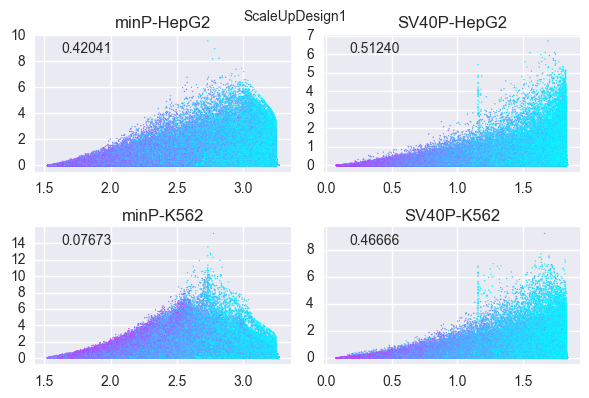

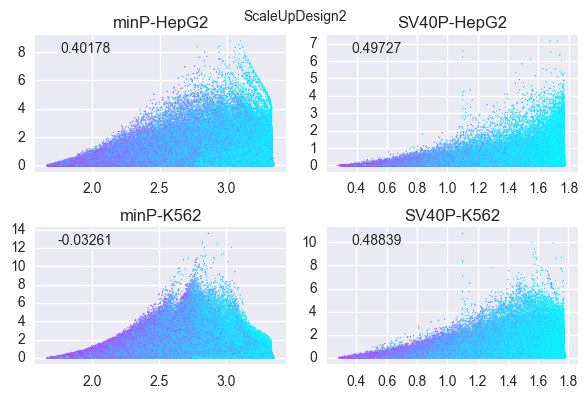

In [24]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        se = lfc_se[designs[j]][:, i][d > 20]
        var = np.var(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        
        spear = stats.spearmanr(se**2, var)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        ax[i%2, i/2].scatter(se**2, var,
                             c = np.log(d+1)[d > 20], cmap='cool', s = 1, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# P-Values

Asymetries correspond to experiments with different activity histograms.

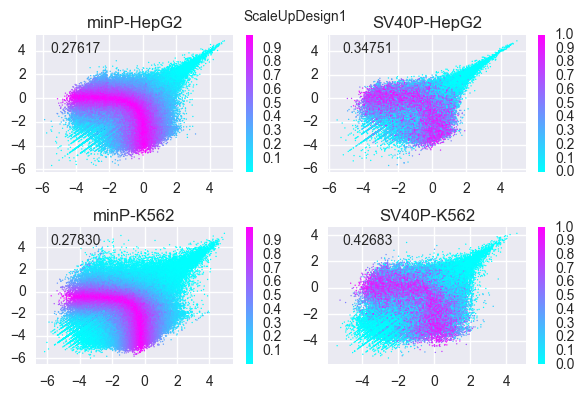

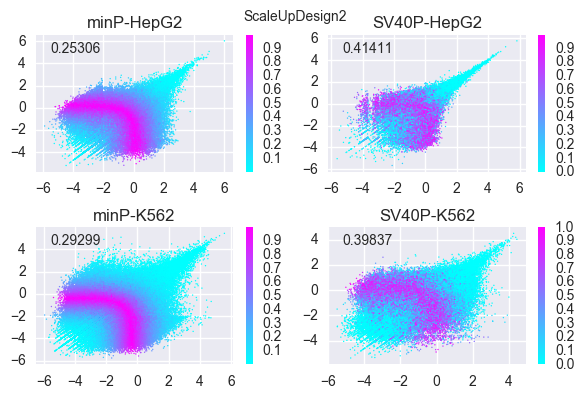

In [25]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        a1, a2 = act(r1, d), act(r2, d)
        pval = pvals[designs[j]][:, i]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        sc = ax[i%2, i/2].scatter(a1, a2,
                             c = pval[d > 20],
                             cmap='cool', s = 1, lw = 0)
        f.colorbar(sc, ax = ax[i%2, i/2])
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

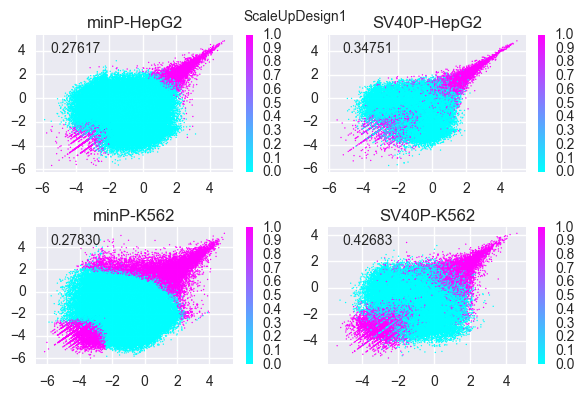

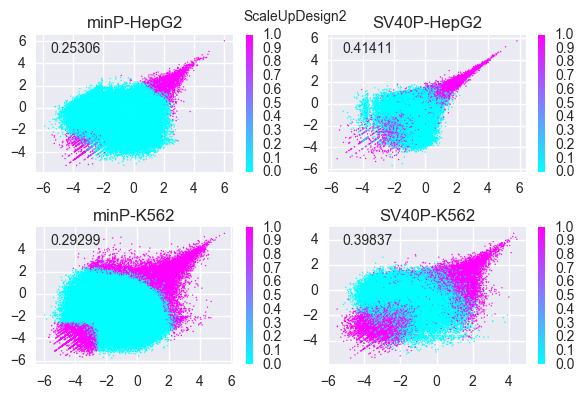

In [26]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        a1, a2 = act(r1, d), act(r2, d)
        pval = pvals[designs[j]][:, i]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        sc = ax[i%2, i/2].scatter(a1, a2,
                             c = pval[d > 20] < .1,
                             cmap='cool', s = 1, lw = 0)
        f.colorbar(sc, ax = ax[i%2, i/2])
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# Divide into DE v. not DE

This is exciting! For many of the samples the pvals partition the data into an uncorrelated ~DE section and a highly correlated DE section.

For samples with greatly different activity histograms, this trend does not hold...

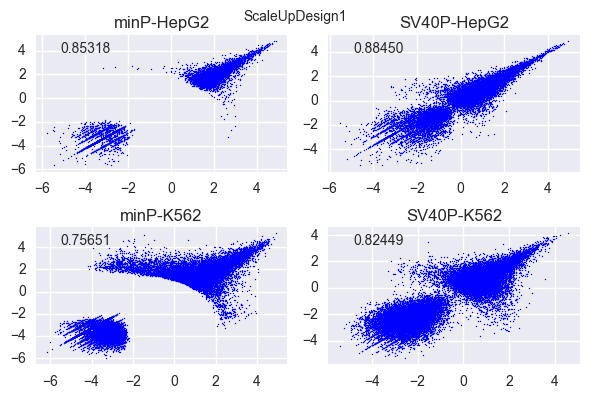

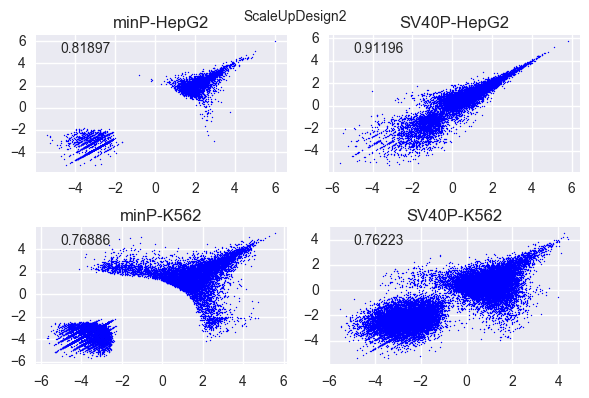

In [27]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        pval = pvals[designs[j]][:, i][d > 20]
        a1, a2 = act(r1, d)[pval < .1], act(r2, d)[pval < .1]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        sc = ax[i%2, i/2].scatter(a1, a2, s = 1, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

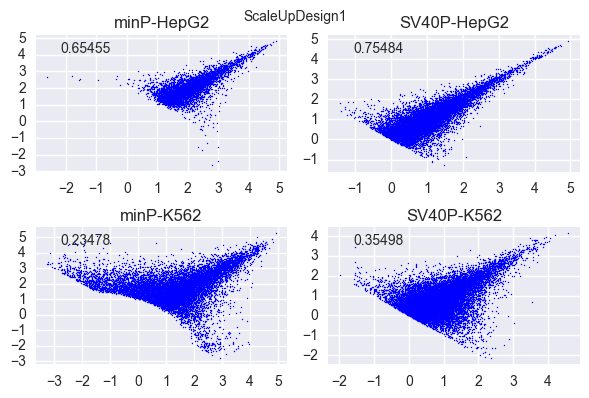

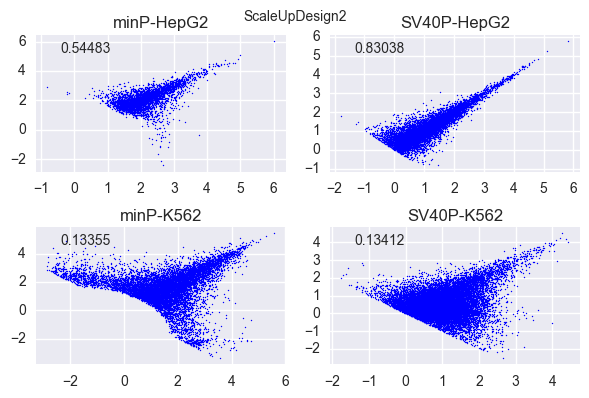

In [28]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        m = np.mean(np.vstack([act(r1, d), act(r2, d)]).T, axis = 1)
        pval = pvals[designs[j]][:, i][d > 20]
        
        idx = np.logical_and(pval < .1, m > 0)
        
        a1, a2 = act(r1, d)[idx], act(r2, d)[idx]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        sc = ax[i%2, i/2].scatter(a1, a2, s = 1, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

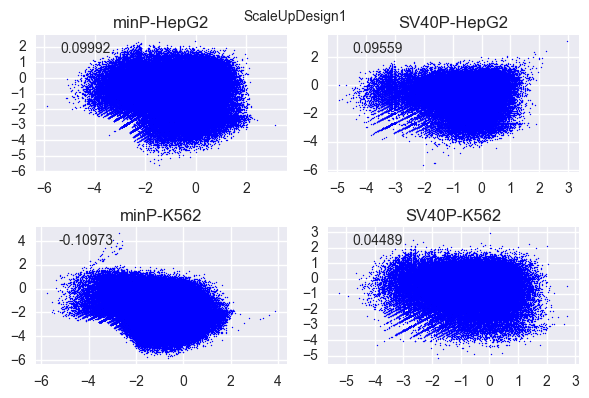

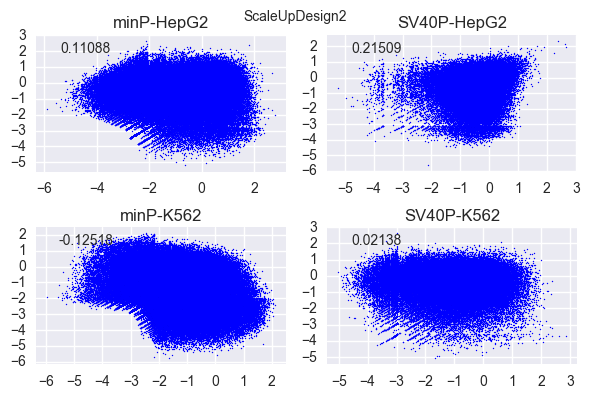

In [29]:
for j in range(2):
    f, ax = plt.subplots(2, 2)
    f.suptitle(designs[j])
    for i in range(4):
        ax[i%2, i/2].set_title(header[i])
        r1, r2 = rna1[designs[j]][:, i], rna2[designs[j]][:, i]
        d = dna[designs[j]][:, i]
        pval = pvals[designs[j]][:, i][d > 20]
        a1, a2 = act(r1, d)[pval > .2], act(r2, d)[pval > .2]
        
        spear = stats.spearmanr(a1, a2)[0]
        ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
        
        sc = ax[i%2, i/2].scatter(a1, a2, s = 1, lw = 0)
        
        
        ax[i%2, i/2].axis('tight')
    plt.tight_layout()
    plt.show()

# Merge Designs

- Designs show very similar histograms, so merging them as is seems fine!
- Also, the correlation stays about the same as when the designs are done seperately.

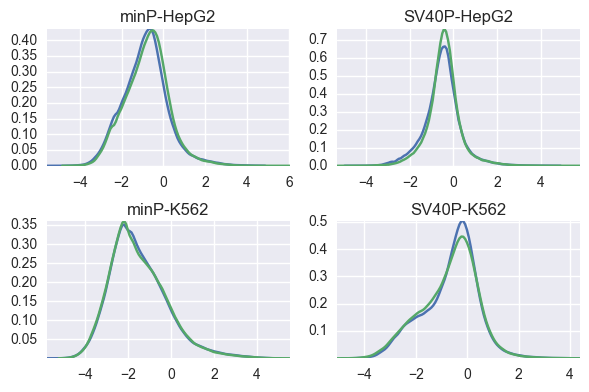

In [40]:
f, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i%2, i/2].set_title(header[i])
    for design in designs:
        r1, r2 = rna1[design][:, i], rna2[design][:, i]
        d = dna[design][:, i]
        sns.kdeplot((act(r1, d) + act(r2, d)) / 2.0,
                    ax = ax[i%2, i/2], cut = 0)
    ax[i%2, i/2].axis('tight')
plt.tight_layout()
plt.show()

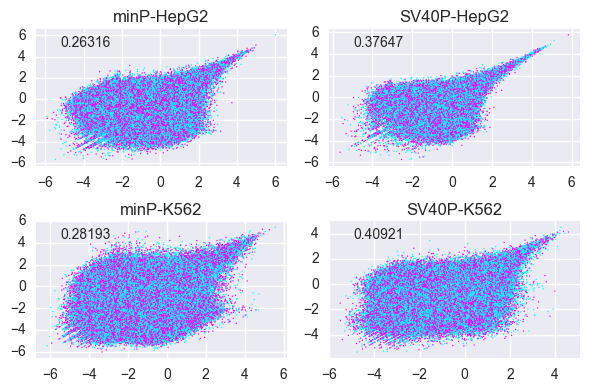

In [46]:
f, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i%2, i/2].set_title(header[i])
    a1, a2, d_m, design_len = [], [], [], []
    for design in designs:
        r1, r2 = rna1[design][:, i], rna2[design][:, i]
        d = dna[design][:, i]
        a1 += list(act(r1, d, -1))
        a2 += list(act(r2, d, -1))
        d_m += list(d)
        design_len += [sum(d > 20)]
    a1, a2, d_m = np.array(a1), np.array(a2), np.array(d_m)
    colors = np.array([1] * design_len[0] + [2] * design_len[1])
    
    # Shuffle, otherwise plot all of on color on top
    state = np.random.get_state()
    np.random.shuffle(colors)
    np.random.set_state(state)
    np.random.shuffle(a1)
    np.random.set_state(state)
    np.random.shuffle(a2)
    np.random.set_state(state)
    np.random.shuffle(d_m)
    
    spear = stats.spearmanr(a1[d_m > 20], a2[d_m > 20])[0]
    
    ax[i%2, i/2].text(0.2, 0.9, '%.5f' % spear,
                          ha='center', va='center',
                          transform=ax[i%2, i/2].transAxes)
    
    sc = ax[i%2, i/2].scatter(a1[d_m > 20], a2[d_m > 20],
                              s = 1, lw = 0,
                              c = colors, cmap = 'cool')
    ax[i%2, i/2].axis('tight')
plt.tight_layout()
plt.show()

# Write data to files

In [30]:
OUT_DIR = '../enhancer_data/kellis/activities'
for design in designs:
    # Raw data
    n = names[design].reshape(-1, 1)
    r1, r2 = rna1[design], rna2[design]
    d = dna[design]
    
    # Activities
    a1 = np.vstack([act(r1[:, i], d[:, i], -1) for i in range(4)]).T
    a2 = np.vstack([act(r1[:, i], d[:, i], -1) for i in range(4)]).T
    a = (a1 + a2) / 2.0
        
    # DESeq info
    l = lfc[design]
    l_mle = lfc_mle[design]
    l_se = lfc_se[design]
    pval = pvals[design]
    
    data = np.hstack([d, r1, r2, a, l, l_mle, l_se, pval]).astype('string')
    h = ['dna', 'rna1', 'rna2', 'activity', 'lfc', 'lfcMLE', 'lfeSE', 'pval']
    
    title = np.array(['ID'] + ["{}-{}".format(d,e) for d in h for e in header])
    print title.shape, n.shape, data.shape, np.hstack([n, data]).shape
    fn = "{}/{}.tsv".format(OUT_DIR, design)
    np.savetxt(fn, np.vstack([title, np.hstack([n, data])]), fmt = '%s', delimiter = '\t')

(33,) (243573, 1) (243573, 32) (243573, 33)
(33,) (243564, 1) (243564, 32) (243564, 33)
